# Using the Switching Regression to be Robust to Misclassification for Ethiopian Maize Adoption

In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
%autoreload 2
import pandas as pd
import numpy as np
from itertools import permutations
from linearmodels import PanelOLS
import sys
sys.path.append("../../uganda-uber-switching-reg/uganda_uber_switching_reg")
from ml_switching_reg.mle import DriverSpecificProbUberMLE
from tqdm.notebook import tqdm
from io import StringIO
import matplotlib.pyplot as plt


In [76]:
df.groupby('wave').count()

,holder_id,household_id,seedtype,harvest_kg,parcesizeHA,parcesizeHA_wiz,urea_kg,dap_kg,hhlabor,hiredmen,...,h2015_grn,h2015_sen,hhd_psnp,hhm_psnp,hh_dpsnp,hh_dpsnppc,hh_ipsnp,hh_dwpsnp,hhea_psnp,flivman
wave,,,,,,,,,,,,,,,,,,,,,
1.0,1755,1755,1755,1755,1755,1755,1755,1755,1755,1755,...,0,0,0,0,0,0,0,0,0,0
2.0,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835,...,0,0,0,0,0,0,0,0,0,0
3.0,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835,...,1803,1803,1803,145,145,145,145,144,1803,1685


In [132]:
df = pd.read_stata("../data/full_panel_rain_traj.dta")

trajectories = (
    df
    .dropna(subset= ['impmaize'])
    .groupby(['holder_id'])['impmaize']
    .agg(trajectories = list)
    .assign(len_traj = lambda df: df['trajectories'].apply(lambda x: len(x)))
    .query("len_traj == 3")
    .drop(['len_traj'], axis=1)
    .assign(trajectories = lambda df: df['trajectories'].astype(str))
    .pipe(pd.get_dummies)
    .rename(lambda x: x.replace('.0', '').replace(',', '').replace('[', '').replace(']', '').replace(' ', ''), axis=1)
    )

# merge with df

merged_df = (
    df
    .merge(trajectories, 
           left_on= ['holder_id'], 
           right_index=True)

    )

merged_df = df.pipe(pd.get_dummies, columns = ['trajectory']).rename(lambda x: x.replace('.0', '').replace(',', '').replace('[', '').replace(']', '').replace(' ', ''), axis=1)
trajectories = merged_df.set_index('holder_id').filter(like= 'trajectory_')




/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/pandas/io/stata.py:1514: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [79]:
# create misclassification matrices for each trajectory

purity_95 = pd.DataFrame(data=[[.863, .1370],
                              [.2958, .7042]], index=[0, 1], 
                                columns=[0,1])

dna_dtm = pd.DataFrame(data=[[.9709, .0291],
                              [.8678, .1322]], index=[0,1], 
                                columns=[0,1])

dna_2010 = pd.DataFrame(data=[[.859, .141],
                              [.6281, .3719]], index=[0,1], 
                                columns=[0,1])

In [80]:
from cProfile import label


with open("../results/tables/purity_table.tex", 'w') as f:
    f.write(purity_95.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:purity95', caption='Misclassification for Pu'))
    
with open("../results/tables/dna_dtm_table.tex", 'w') as f:
    f.write(dna_dtm.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:dna_dtm'))
    
with open("../results/tables/dna_2010_table.tex", 'w') as f:
    f.write(dna_2010.applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, label='tbl:dna_2010'))

In [112]:
trajectory_nums = trajectories.columns.str.replace("trajectory_", '').tolist()

In [113]:
# Now the magic...
# Need to take these static probabilities and turn the into a probability for each trajectory
# So my confusion matrix for each will be 2^3 x 2^3

trajectory_nums = trajectories.columns.str.replace("trajectories_", '').tolist()

def confusion_matrix(misclass_mat):
    confusion_matrix = pd.DataFrame(index=trajectory_nums, columns=trajectory_nums)
    
    for traj_self_reported in trajectory_nums:
        for traj_misclassified in trajectory_nums:
            traj_int_self_reported = [int(i) for i in list(traj_self_reported)]
            traj_int_misclassified = [int(i) for i in list(traj_misclassified)]
            confusion_matrix.loc[traj_self_reported, traj_misclassified] = \
                misclass_mat.loc[traj_int_self_reported[0], traj_int_misclassified[0]] * \
                    misclass_mat.loc[traj_int_self_reported[1], traj_int_misclassified[1]] * \
                        misclass_mat.loc[traj_int_self_reported[2], traj_int_misclassified[2]]
    
    return confusion_matrix
    

In [83]:
with open("../results/tables/misclass_95purity.tex", 'w') as f:
    
    f.write(confusion_matrix(purity_95).applymap(lambda x: f"{x:0.3f}").style.to_latex(hrules=True, 
                                                   label='tab:cm',
                                                   caption='Misclassification Matrix for Seed Adoption based on DNA Fingerprinting'))

In [118]:
# Let's see what happens!

trajectory_df = (
    merged_df
    .set_index(['holder_id', 'wave'])
    .filter(like='trajectory_')
    .idxmax(axis=1)
    .reset_index()
    .rename({0 : 'trajectory'}, axis=1)
    .assign(trajectory = lambda df: df['trajectory'].str.replace('trajectory_', ''))
    .merge(merged_df, on = ['holder_id', 'wave'])
    )



In [185]:
full_df_summary = (
    trajectory_df
    .merge(trajectory_df[['wave', 'trajectory', 'impmaize']]
           .drop_duplicates(), on=['wave'], 
           suffixes=('_true', '_misclass'))
    .set_index(['holder_id', 'wave', 'trajectory_misclass'])
    )

full_df = (
    trajectory_df
    .merge(trajectory_df[['wave', 'trajectory', 'impmaize']]
           .drop_duplicates(), on=['wave'], 
           suffixes=('_true', '_misclass'))
    .set_index(['holder_id', 'wave', 'trajectory_misclass'])
    .query("YIELD_cropcutdry_tr !=0")
    .assign(log_yield = lambda df: np.log(df['YIELD_cropcutdry_tr']))
    .dropna(subset=['log_yield', 'impmaize_misclass', 'yrseduc', "age_head", "sex_head",  'title', "parcesizeHA", "hhlabor", "hiredlabor", 'anntot_avg'])
    )

In [186]:
classifier_pred = (
    full_df
    .filter(like='trajectory_')
    .reset_index()
    .drop(columns=['trajectory_misclass', 'trajectory_true'])
    .drop_duplicates()
    .set_index(['holder_id', 'wave'])
    )

In [187]:
full_df

trajectory_true    household_id  \
holder_id        wave trajectory_misclass                                   
0101020140301601 1.0  000                             000  01010201403016   
                      001                             000  01010201403016   
                      010                             000  01010201403016   
                      100                             000  01010201403016   
                      110                             000  01010201403016   
...                                                   ...             ...   
1301010140514901 3.0  100                             000  13010101405149   
                      110                             000  13010101405149   
                      101                             000  13010101405149   
                      111                             000  13010101405149   
                      011                             000  13010101405149   

                                              seedtype  harvest_kg  \
holder_id        wave trajectory_misclass                            
0101020140301601 1.0  000                  Traditional       200.0   
                      001                  Traditional       200.0   
                      010                  Traditional       200.0   
                      100                  Traditional       200.0   
                      110                  Traditional       200.0   
...                                                ...         ...   
1301010140514901 3.0  100                  Traditional       253.0   
                      110                  Traditional       253.0   
                      101                  Traditional       253.0   
                      111                  Traditional       253.0   
                      011                  Traditional       253.0   

                                           parcesizeHA  parcesizeHA_wiz  \
holder_id        wave trajectory_misclass                                 
0101020140301601 1.0  000                     0.389516         0.389516   
                      001                     0.389516         0.389516   
                      010                     0.389516         0.389516   
                      100                     0.389516         0.389516   
                      110                     0.389516         0.389516   
...                                                ...              ...   
1301010140514901 3.0  100                     0.523940         0.523940   
                      110                     0.523940         0.523940   
                      101                     0.523940         0.523940   
                      111                     0.523940         0.523940   
                      011                     0.523940         0.523940   

                                           urea_kg  dap_kg  hhlabor  hiredmen  \
holder_id        wave trajectory_misclass                                       
0101020140301601 1.0  000                      0.0    10.0      6.0       0.0   
                      001                      0.0    10.0      6.0       0.0   
                      010                      0.0    10.0      6.0       0.0   
                      100                      0.0    10.0      6.0       0.0   
                      110                      0.0    10.0      6.0       0.0   
...                                            ...     ...      ...       ...   
1301010140514901 3.0  100                      7.0     0.0     68.0       0.0   
                      110                      7.0     0.0     68.0       0.0   
                      101                      7.0     0.0     68.0       0.0   
                      111                      7.0     0.0     68.0       0.0   
                      011                      7.0     0.0     68.0       0.0   

                                           ...  trajectory_000  \
holder_id        wave trajectory_

In [188]:
# Create nonlinear-MLE version of switching_reg for restricted model of GRC
from lib2to3.pgen2.driver import Driver
from scipy.stats import norm

class MisclassifiedGRC(DriverSpecificProbUberMLE):
    
    def _ll(self, params):                
        cm = self.cm.astype(float)

        # generate X so that we can for absorbed variables
        X = self.X
        
        if X.ndim ==1:
            raise Exception("Regimes not of equal size...")
        
        results_df = pd.Series(params, index=self._param_order)
        controls_df = results_df.loc[lambda df: ~df.index.str.contains('trajectory|impmaize|phi|sigma|mu_always')]
        beta_df = results_df.loc[~results_df.index.isin(['sigma', 'phi', 'mu_always'])]
        trajectories = beta_df.filter(regex='^trajectory_')
        trajectories_impmaize_names = self.exog_cat.filter(like='impmaize_misclass:').columns.tolist()        
        impmaize = beta_df.filter(regex='impmaize_misclass$').values[0]
        sigma = results_df.loc[results_df.index=='sigma'].values[0]
        phi = results_df.loc[results_df.index=='phi'].values[0]
        mu_always = results_df.loc[results_df.index=='mu_always'].values[0]
        
        # Now we build the expression
        # mu
        X_mu = X[:, :, self.exog_cat.columns.get_indexer(trajectories.index)]
        mu = X_mu @ trajectories.values
        
        # delta
        X_delta = X[:, :, self.exog_cat.columns.get_loc('impmaize_misclass')]
        delta = X_delta * impmaize
        
        # phi
        switcher_loc = (
            pd.Series(index=trajectories_impmaize_names, 
                                 data=self.exog_cat.columns.get_indexer(trajectories_impmaize_names))
            )
        
        trajectory_loc = (
            pd.Series(index=trajectories.index, 
                                 data=self.exog_cat.columns.get_indexer(trajectories.index))
            )
        
        base_trajectory = trajectories.loc['trajectory_001']
        x_base = X[:,:, trajectory_loc.loc['trajectory_001']]

        phi_exp = 0
        
        for name, param in trajectories.drop(['trajectory_000', 'trajectory_001']).iteritems():
            
            x_m = X[:,:, trajectory_loc.loc[name]]
            
            phi_exp += phi*((param*x_m) - (base_trajectory*x_base))*X[:,:, switcher_loc.loc[f"impmaize_misclass:{name}"]]
            
        # mu_always
        X_mu_always = (mu_always + phi*(mu_always - (base_trajectory*x_base)))*X[:,:, switcher_loc.loc['impmaize_misclass:trajectory_111']]
        
        # controls
        if not controls_df.empty:
            controls = X[:,:, self.exog_cat.columns.get_indexer(controls_df.index)] @ controls_df.values
            Xb = mu + delta + phi_exp + X_mu_always + controls
        else:
            Xb = mu + delta + phi_exp + X_mu_always
        
        rnl = norm.pdf(np.squeeze(self.y), Xb, scale=np.abs(sigma)).T

        # get row_maxes for probabilities
        row_maxes = self.p.max(axis=1, keepdims=True)
        class_ind = np.where(self.p==row_maxes, self.p, 0)
        return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
    
    @property
    def exog_names(self):
        exog_names = [x for x in self.data.xnames \
            if x not in ['impmaize_misclass:trajectory_001',
                        'impmaize_misclass:trajectory_010',
                        'impmaize_misclass:trajectory_011',
                        'impmaize_misclass:trajectory_100',
                        'impmaize_misclass:trajectory_101',
                        'impmaize_misclass:trajectory_110',
                        'impmaize_misclass:trajectory_111'] 
            ]
        
        return exog_names + ['sigma', 'mu_always', 'phi']
    
    def fit(
        self,
        method=None,
        maxiter=10000,
        maxfun=5000,
        sigma_bound=None,
        cluster_var=None,
        show_ols=False,
        start_params_res=None,
        **kwds,
    ):

        results_df, pols_res = self._start_params(show_ols=show_ols, 
                                                  cluster_var=cluster_var,
                                                  start_params_res=start_params_res)
        
        self._param_order = results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')].index.append(pd.Index(['mu_always', 'phi']))
        
        mu_always_start = self.endog_cat.loc[self.exog_cat['impmaize_misclass'] == 1].mean().values[0]
        phi_start = -0.1
        
        start_params = np.append(results_df.loc[lambda df: ~ df.index.str.contains(r'impmaize_misclass:')], 
                                 [[mu_always_start], [phi_start]])
        
        # if kwds.get('cov_type') is None:
        #     cov_type='cluster'
        #     cov_kwds = {'groups' : cluster_var,
        #                 'df_correction' : True,
        #                 'use_correction' : True}
        # else:
        #     cov_type = kwds.pop('cov_type', None)
        #     cov_kwds = kwds.pop('cov_kwds', None) 

        print("Optimizing...")
        optimize = super(DriverSpecificProbUberMLE, self).fit(
            method=method,
            start_params=start_params,
            maxiter=maxiter,
            maxfun=maxfun,
            eps=1e-08,
            ftol=1e-10,
            bounds=None,
            # cov_type= cov_type,
            # cov_kwds = cov_kwds,
            use_t=True,
            **kwds
        )
        
        return optimize, pols_res
    
no_stayers = classifier_pred.drop(columns=['trajectory_111']).columns.tolist()
switchers = classifier_pred.drop(columns=['trajectory_000']).columns.tolist()

formula = "log_yield ~ -1 + " + ' + '.join(no_stayers) + ' + ' \
        + ' + '.join([f"{s}:impmaize_misclass" for s in switchers])\
                + '+ impmaize_misclass + yrseduc + age_head +  sex_head +  title + parcesizeHA + hhlabor+ hiredlabor' 

res = PanelOLS.from_formula(formula, 
                            data=full_df.reset_index('trajectory_misclass').query("trajectory_true==trajectory_misclass"),
                            check_rank=False).fit()

mod = MisclassifiedGRC.from_formula(formula, 
                            data=full_df, 
                            classifier_pred = classifier_pred,
                            check_absorbed=False,
                            cm = confusion_matrix(purity_95).T.values)

sr, pols = mod.fit(method='bfgs',
        start_params_res=res)



Initializing...
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False. skipping...
Creating starting values...
Optimizing...


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: ftol, maxfun, bounds, eps. After release 0.14, this will raise.
  warnings.warn(
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_16078/1802246898.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_16078/1802246898.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1hrtn3kl9cq0gsx95c6lr0000gn/T/ipykernel_16078/1802246898.py:72: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/var/folders/22/d2d1h

Optimization terminated successfully.
         Current function value: 1.354849
         Iterations: 66
         Function evaluations: 80
         Gradient evaluations: 72


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [189]:
mod_unrestricted = DriverSpecificProbUberMLE.from_formula(
    formula=formula,
    data=full_df,
    classifier_pred=classifier_pred,
    cm=confusion_matrix(purity_95).T.values,
    check_absorbed=False
)

sr_unres, pols_unres = mod_unrestricted.fit(method='bfgs',
        start_params_res=res, cov_type='cluster',
        cov_kwds={'groups' : full_df.reset_index('trajectory_misclass').query("trajectory_misclass == trajectory_true").trajectory_true})

/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method bfgs is: gtol, norm, epsilon. The list of unsupported keyword arguments passed include: ftol, maxfun, bounds, eps. After release 0.14, this will raise.
  warnings.warn(
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/ml_switching_reg/mle.py:376: RuntimeWarning: divide by zero encountered in log
  return np.log((rnl*(class_ind@cm.T)).sum(axis=1))
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/tools/numdiff.py:157: RuntimeWarning: invalid value encountered in double_scalars
  grad[k, :] = (f(*((x+ei,)+args), **kwargs) -
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/ml_switching_reg/mle.py:376: RuntimeWarning: divide 

Initializing...
exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False. skipping...
Creating starting values...
Optimizing...
Optimization terminated successfully.
         Current function value: 1.350807
         Iterations: 113
         Function evaluations: 128
         Gradient evaluations: 119


/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2694: UserWarning: df_model + k_constant differs from nparams
  warnings.warn("df_model + k_constant differs from nparams")
/Users/lordflaron/anaconda3/envs/ethiopia-tech-adoption/lib/python3.9/site-packages/statsmodels/base/model.py:2696: UserWarning: df_resid differs from nobs - nparams
  warnings.warn("df_resid differs from nobs - nparams")


In [190]:
full_df_short = full_df.reset_index('trajectory_misclass').query("trajectory_true==trajectory_misclass")
full_df_short_summary = full_df_summary.reset_index('trajectory_misclass').query("trajectory_true==trajectory_misclass")

In [236]:
def add_note(table, note, n):
    
    return table.replace("\\end{tabular}\n\\end{table}", f"\\multicolumn{{{n}}}{{l}}{{Note: {note}}}\n\\end{{tabular}}\n\\end{{table}}")


fancy_rename_dict = {'parcesizeHA_wiz' : 'Parcel Size',
              'hhlabor' : 'Household Labor for Harvest (Days)',
              'hiredlabor' : 'Hired Labor for Harvest (Days)',
              'age_head_wiz' : 'Age of Household Head',
              'sex_head' : 'Sex of Household Head',
              'yrseduc' : 'Years of Education of Household Head',
              "anntot_avg" : "Total Rainfall (mm)",
              'title' : 'Does Household have Title to land?',
            'YIELD_cropcutdry_tr' : 'Crop Cut Dry Yield (kg/ha)',
            'YIELD_selfr_tr' : 'Self-reported Yields (kg/ha)'
              }

def num_format(x):
  if isinstance(x, str):
    return x
  
  if x>900:
    return "{:,.0f}".format(x)
  else:
    return "{:.2f}".format(x)

summary_latex_aux = (
    full_df_short
    .reset_index()
    .assign(female = lambda df: (df['sex_head'] == 2).astype(int))
    .rename({'wave' : "Wave"}, axis=1)
    [list(fancy_rename_dict.keys()) + ['Wave']]
    .groupby('Wave')
    .describe()
    .loc[:, (slice(None), ['count', 'mean', 'std'])].T
    .rename({'count' : 'N', 'mean' : 'Mean', 'std' : 'Std. Dev.', 'min' : 'Min', 'max' : 'Max'}, axis=0)
    .rename(fancy_rename_dict)
    .applymap(num_format)
    .rename({1 : '1', 2: '2', 3:'3'},axis=1)
    )


In [263]:
fancy_names = list(fancy_rename_dict.values()) 


In [285]:
cnts = summary_latex_aux.loc[(fancy_names, ('Mean', 'Std. Dev.')), :].unstack().loc[list(fancy_rename_dict.values())]

In [268]:
yi = summary_latex_aux.loc[(['Crop Cut Dry Yield (kg/ha)', 'Self-reported Yields (kg/ha)'], ['N']), :]

In [360]:
obs = yi.reset_index().set_index('level_1').drop(columns = 'level_0').astype(float).values

In [404]:
summary_latex_almost = (cnts
                        .style
                        .format({('1', 'Std. Dev.') : lambda x: "(" + x + ")",
                                ('2', 'Std. Dev.') : lambda x: "(" + x + ")",
                                ('3', 'Std. Dev.') : lambda x: "(" + x + ")"})
                        # .rename_({'Std. Dev.' : '', 'Mean' : ''}, axis=1)
                        .to_latex(label = "tbl:summary",
                    caption="Summary Statistics for Households",
                    hrules=True, multicol_align='c')
                        .replace("Mean" , '')
                        .replace("Std. Dev.", '')
                        )

In [405]:
print(summary_latex_almost)

\begin{table}
\caption{Summary Statistics for Households}
\label{tbl:summary}
\begin{tabular}{lllllll}
\toprule
Wave & \multicolumn{2}{c}{1} & \multicolumn{2}{c}{2} & \multicolumn{2}{c}{3} \\
 &  &  &  &  &  &  \\
\midrule
Parcel Size & 0.31 & (0.38) & 0.35 & (0.45) & 0.35 & (0.39) \\
Household Labor for Harvest (Days) & 50.09 & (65.58) & 44.17 & (57.21) & 42.35 & (52.83) \\
Hired Labor for Harvest (Days) & 2.67 & (13.26) & 5.39 & (27.82) & 3.33 & (19.73) \\
Age of Household Head & 43.81 & (15.40) & 46.39 & (14.90) & 47.84 & (14.19) \\
Sex of Household Head & 1.14 & (0.35) & 1.13 & (0.34) & 1.16 & (0.37) \\
Years of Education of Household Head & 1.72 & (2.88) & 1.51 & (2.72) & 1.62 & (2.76) \\
Total Rainfall (mm) & 911 & (239.69) & 969 & (245.42) & 921 & (257.29) \\
Does Household have Title to land? & 0.46 & (0.50) & 0.54 & (0.50) & 0.65 & (0.48) \\
Crop Cut Dry Yield (kg/ha) & 392.97 & (257.08) & 957 & (614.84) & 1,108 & (872.33) \\
Self-reported Yields (kg/ha) & 647.57 & (555.40) & 

In [406]:
def multicolumn_add(obs):
    obs_list = []
    for o in obs:
        obs_list.append("\\multicolumn{2}{c}{" + f"{o:.0f}" + '}')
        
    return '&'.join(obs_list)

In [410]:
summary_latex = (summary_latex_almost
      .replace("872.33) \\\\", "872.33) \\\\" +  "\n\\midrule\n" + "N & " + multicolumn_add(obs[0]) + '\\\\' + "\n\\midrule")
      .replace("\\bottomrule", "\\midrule\n" "N & " + multicolumn_add(obs[1]) + '\\\\' + '\n\\bottomrule') 
      )

print(summary_latex)

\begin{table}
\caption{Summary Statistics for Households}
\label{tbl:summary}
\begin{tabular}{lllllll}
\toprule
Wave & \multicolumn{2}{c}{1} & \multicolumn{2}{c}{2} & \multicolumn{2}{c}{3} \\
 &  &  &  &  &  &  \\
\midrule
Parcel Size & 0.31 & (0.38) & 0.35 & (0.45) & 0.35 & (0.39) \\
Household Labor for Harvest (Days) & 50.09 & (65.58) & 44.17 & (57.21) & 42.35 & (52.83) \\
Hired Labor for Harvest (Days) & 2.67 & (13.26) & 5.39 & (27.82) & 3.33 & (19.73) \\
Age of Household Head & 43.81 & (15.40) & 46.39 & (14.90) & 47.84 & (14.19) \\
Sex of Household Head & 1.14 & (0.35) & 1.13 & (0.34) & 1.16 & (0.37) \\
Years of Education of Household Head & 1.72 & (2.88) & 1.51 & (2.72) & 1.62 & (2.76) \\
Total Rainfall (mm) & 911 & (239.69) & 969 & (245.42) & 921 & (257.29) \\
Does Household have Title to land? & 0.46 & (0.50) & 0.54 & (0.50) & 0.65 & (0.48) \\
Crop Cut Dry Yield (kg/ha) & 392.97 & (257.08) & 957 & (614.84) & 1,108 & (872.33) \\
\midrule
N & \multicolumn{2}{c}{247}&\multicolumn{2

In [408]:
with open("../results/tables/summary.tex", 'w') as f:
    f.write(summary_latex)


In [193]:
sr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           MisclassifiedGRC Results                           
==============================================================================
Dep. Variable:              log_yield   Log-Likelihood:                -1319.6
Model:               MisclassifiedGRC   AIC:                             2677.
Method:            Maximum Likelihood   BIC:                             2770.
Date:                Thu, 23 Mar 2023                                         
Time:                        09:41:21                                         
No. Observations:                 974                                         
Df Residuals:                     954                                         
Df Model:                          19                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
age_head              0.0019      0.002      0.895      0.371      -0.002       0.006
hhlabor              -0.0037      0.001     -7.159      0.000      -0.005      -0.003
hiredlabor            0.0016      0.001      1.166      0.244      -0.001       0.004
impmaize_misclass     0.4495      0.205      2.189      0.029       0.047       0.852
parcesizeHA          -0.0057      0.015     -0.376      0.707      -0.036       0.024
sex_head             -0.0326      0.082     -0.395      0.693      -0.194       0.129
title                 0.1350      0.061      2.224      0.026       0.016       0.254
trajectory_000        6.2894      0.147     42.685      0.000       6.000       6.579
trajectory_001        6.4826      0.190     34.095      0.000       6.109       6.856
trajectory_010        6.6213      0.216     30.606      0.000       6.197       7.046
trajectory_011        6.7874      0.216     31.445      0.000       6.364       7.211
trajectory_100        6.7573      0.264     25.632      0.000       6.240       7.275
trajectory_101        7.0348      0.321     21.908      0.000       6.405       7.665
trajectory_110        7.2958      0.313     23.344      0.000       6.683       7.909
yrseduc              -0.0042      0.011     -0.385      0.700      -0.026       0.017
sigma                 0.8592      0.024     36.171      0.000       0.813       0.906
mu_always             7.4270      0.391     19.010      0.000       6.660       8.194
phi                  -0.1608      0.054     -2.956      0.003      -0.267      -0.054
=====================================================================================
"""

In [194]:
mu_freq = merged_df.filter(like='trajectory_').replace().idxmax(axis=1).value_counts(normalize=True, sort=False)

mu_freq.index = mu_freq.index.str.replace("trajectory_", '')

# get mus from sr
sr_df = (
    pd.read_csv(StringIO(sr.summary().tables[1].as_csv()))
    .rename(lambda x: str.strip(x), axis=1)
    .set_index('')
    .rename(index=lambda x: str.strip(x))
    .reset_index()      
    .rename({'' : 'vars'},axis=1)
    .set_index('vars')
    )

In [195]:
# calculate theta

mus = sr_df.filter(regex='trajectory|mu_always', axis=0).coef.values

trajectory_order = ['000', '001', '010', '011', '100', '101', '110', '111']

E_mu = (mu_freq.reindex(trajectory_order).values # reindex so that they're in the same order 
    * mus).sum()

In [196]:
# calculate returns
returns_dict = {k : 0 for k in trajectory_order}

phi = sr_df.query("index == 'phi'").coef.values[0]
mu_always = sr_df.query("index == 'mu_always'").coef.values[0]
base_trajectory = sr_df.query("index == 'trajectory_001'").coef.values[0]
beta = sr_df.query("index == 'impmaize_misclass'").coef.values[0]

## First we do mu_always
returns_dict['111'] = phi*(mu_always - base_trajectory) - beta

## for base
returns_dict['001'] = beta

## Now the rest...
for traj in ['000', '010', '011', '100', '101', '110']:
    returns_dict[traj] = phi*(sr_df.query(f"index == 'trajectory_{traj}'").coef.values[0] - base_trajectory) - beta


In [197]:
mu_df = pd.DataFrame(data = mus-E_mu, index=trajectory_order, columns=['theta'])

returns_df = pd.DataFrame(data=returns_dict.values(), index=returns_dict.keys(), columns=['returns'])

# Load GMM Data
gmm_df = pd.read_csv("../results/data/theta.csv").assign(trajectory=trajectory_order).set_index('trajectory')

In [198]:
theta_all = mu_df.merge(gmm_df, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))
returns_all = returns_df.merge(theta_all, left_index=True, right_index=True, suffixes=('_misclass', '_normal'))


In [199]:
full_df_short_theta = full_df_short.merge(theta_all, left_on=['trajectory_true'], right_index=True)

In [200]:
PanelOLS.from_formula("theta_normal ~ eviarea_avg + dist_road + dist_popcenter + dist_market + dist_borderpost + dist_admctr", data=full_df_short_theta).fit(cov_type='clustered',
                                                                                  cluster_entity=True)

Dep. Variable:,theta_normal,R-squared:,0.0221
Estimator:,PanelOLS,R-squared (Between):,0.0161
No. Observations:,974,R-squared (Within):,0.0000
Date:,"Thu, Mar 23 2023",R-squared (Overall):,0.0221
Time:,09:41:21,Log-likelihood,264.34
Cov. Estimator:,Clustered,,
,,F-statistic:,3.6411
Entities:,1228,P-value,0.0014
Avg Obs:,0.7932,Distribution:,"F(6,968)"
Min Obs:,0.0000,,
Max Obs:,3.0000,F-statistic (robust):,3.4060


In [201]:
PanelOLS.from_formula("theta_misclass ~ eviarea_avg + dist_road + dist_popcenter + dist_market + dist_borderpost + dist_admctr", data=full_df_short_theta).fit(cov_type='clustered',
                                                                                  cluster_entity=True)

Dep. Variable:,theta_misclass,R-squared:,0.1335
Estimator:,PanelOLS,R-squared (Between):,0.1185
No. Observations:,974,R-squared (Within):,0.0000
Date:,"Thu, Mar 23 2023",R-squared (Overall):,0.1335
Time:,09:41:21,Log-likelihood,-461.63
Cov. Estimator:,Clustered,,
,,F-statistic:,24.867
Entities:,1228,P-value,0.0000
Avg Obs:,0.7932,Distribution:,"F(6,968)"
Min Obs:,0.0000,,
Max Obs:,3.0000,F-statistic (robust):,24.870


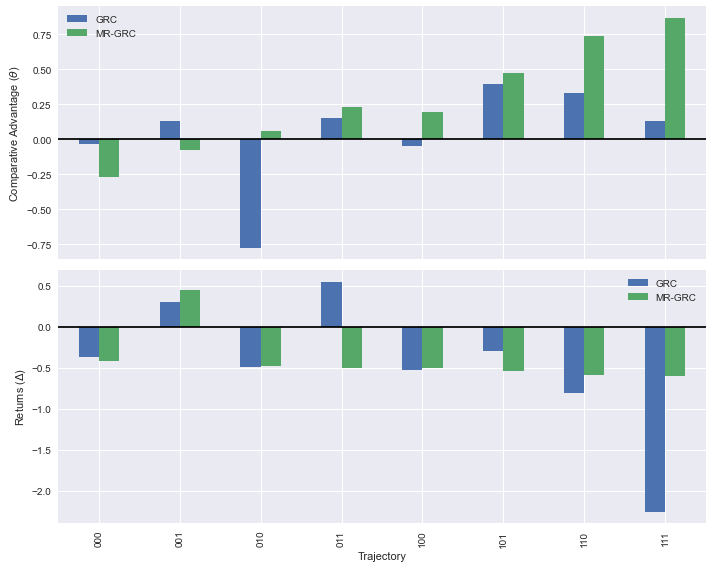

In [202]:
plt.style.use('seaborn')

fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

# Theta
theta_all[[ 'theta_normal', 'theta_misclass']].plot.bar(ax=ax[0], legend=False)

# Returns
returns_all[['returns_normal', 'returns_misclass']].plot.bar(ax=ax[1], legend=False)

ax[0].legend(['GRC', 'MR-GRC'])
ax[1].legend(['GRC', 'MR-GRC'])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")


plt.tight_layout()\

plt.savefig("../results/figures/mr-theta.png", dpi=300)

## Number of Times Adopted

In [203]:
num_adoption_df = (
    pd.read_csv("../results/data/num_adoption.csv")
)

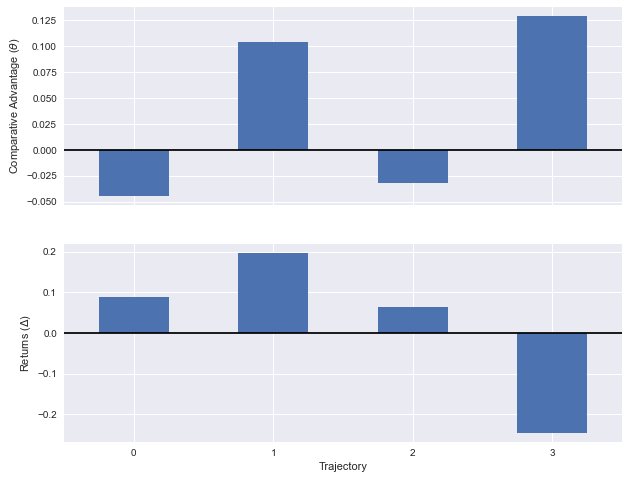

In [204]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(10,8))

num_adoption_df['theta'].plot.bar(ax=ax[0])

num_adoption_df['returns'].plot.bar(ax=ax[1])

ax[0].axhline(0, color='black')
ax[1].axhline(0, color='black')

ax[0].set_ylabel(r"Comparative Advantage ($\theta$)")
ax[1].set_ylabel("Returns ($\Delta$)")
ax[1].set_xlabel("Trajectory")

ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

plt.savefig("../results/figures/num_adoption.png", dpi=300)

## Do Weak-ID Procedure

In [205]:
def weak_id_test(res, start=-100, stop=100, inc=0.1, adoption_col = 'impmaize'):
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros((ranger.size, trajectories.size))
    for i, phi in enumerate(tqdm(ranger)):
        for j, traj in enumerate(trajectories):
            test = f"trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001)"
            mat[i, j] = res.t_test(test).pvalue
            
    df= pd.DataFrame(columns = trajectories,
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def weak_id_joint_test(res, start=-100, stop=100, inc=0.1, adoption_col='impmaize'):
    
    trajectories = np.array(["010", "011", "100", "101", "110"])
    ranger = np.arange(start, stop, inc)
    mat = np.zeros(ranger.size)
    
    for i, phi in enumerate(tqdm(ranger)):
        joint_test_list = [f"(trajectories_{traj} - trajectories_001 = {phi}*({adoption_col}:trajectories_{traj} - {adoption_col}:trajectories_001))" \
            for traj in trajectories]
    
        joint_test = ' , '.join(joint_test_list)
        mat[i] = res.f_test(joint_test).pvalue

    df= pd.DataFrame(columns = ['joint'],
                 index = pd.Index(ranger),
                 data=mat)
            
    return df

def phi_ci(weak_id_df):
    
    phi_p_min = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].min()
    phi_p_max = weak_id_df[weak_id_df.apply(lambda x: x > 0.05)].max()
    
    phi_df = pd.DataFrame(
        index = ['min', 'max'],
        columns = weak_id_df.columns
    )
    
    for col, mi, ma in zip(weak_id_df.columns, phi_p_min, phi_p_max):
        try:
            phi_df.loc['min', col] = weak_id_df.index[weak_id_df[col] == mi].values[0]
            phi_df.loc['max', col] = weak_id_df.index[weak_id_df[col] == ma].values[0]
        except IndexError:
            print(f"""Might be NaNs: 
                  phi_min = {phi_p_min.values[0]}
                  phi_max = {phi_p_max.values[0]}
                  """)
        
    return phi_df

In [206]:
weak_id_test = weak_id_test(sr, adoption_col='impmaize_misclass')

  0%|          | 0/2000 [00:00<?, ?it/s]

PatsyError: unrecognized token in constraint
    trajectories_010 - trajectories_001 = -100.0*(impmaize_misclass:trajectories_010 - impmaize_misclass:trajectories_001)
    ^

In [ ]:
joint_test = weak_id_joint_test(sr, adoption_col='impmaize_misclass')

: 

In [ ]:
phi_ci(weak_id_test)

: 

In [ ]:
phi_ci(joint_test)

: 